[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/027_pytorch_intro/pytorch_intro.ipynb)

# Pytorch - MLP

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline
import random

# Preprocesamiento

In [ ]:
import os
from PIL import Image
import glob


dataset_path = "bloodcells_dataset"

classes = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']

X = []
Y = []


img_size = 28


for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.exists(class_path):
        print(f"Advertencia: No se encuentra la carpeta {class_path}")
        continue

    image_paths = glob.glob(os.path.join(class_path, '*.jpg')) + \
                  glob.glob(os.path.join(class_path, '*.jpeg')) + \
                  glob.glob(os.path.join(class_path, '*.png'))

    print(f"Cargando {len(image_paths)} imágenes de la clase {class_name}")

    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size))
            img_array = np.array(img).reshape(-1) / 255.0
            X.append(img_array)
            Y.append(class_idx)
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int64) 


print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de Y: {Y.shape}")

Cargando 1218 imágenes de la clase BASOPHIL
Cargando 3117 imágenes de la clase EOSINOPHIL
Cargando 1551 imágenes de la clase ERYTHROBLAST
Cargando 2895 imágenes de la clase IG
Cargando 1214 imágenes de la clase LYMPHOCYTE
Cargando 1420 imágenes de la clase MONOCYTE
Cargando 3329 imágenes de la clase NEUTROPHIL
Cargando 2348 imágenes de la clase PLATELET
Tamaño de X: (17092, 2352)
Tamaño de Y: (17092,)


# Visualización de prueba

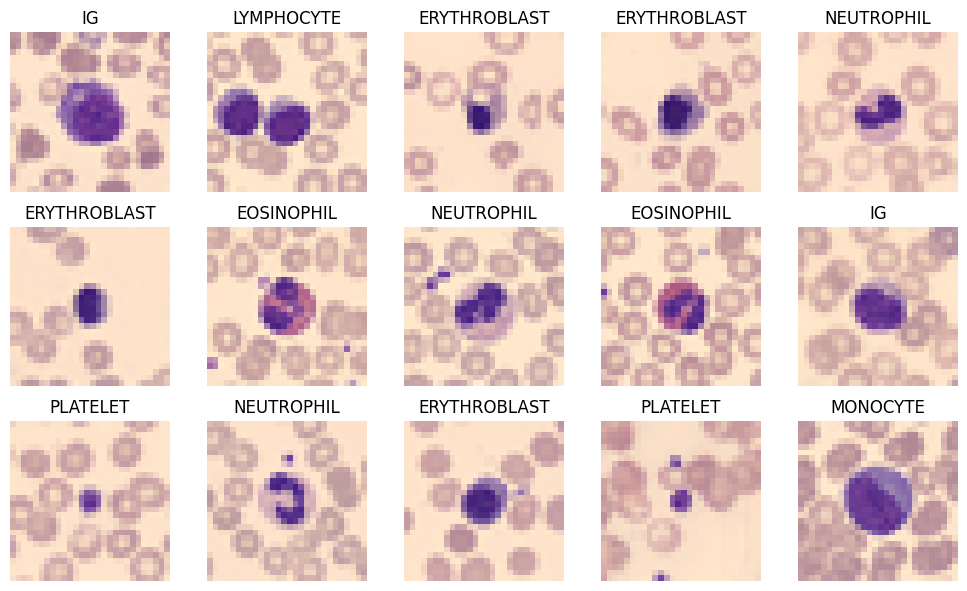

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        img = X[ix]
        
        img_reshaped = img.reshape(28, 28, 3)
        
    
        plt.imshow(img_reshaped)
        plt.axis("off")
        
        class_names = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']
        plt.title(class_names[Y[ix]])
        
plt.tight_layout()
plt.show()

# División Aleatoria de Datos en Conjuntos de Entrenamiento y Prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape} imágenes, {y_train.shape} etiquetas")
print(f"Datos de prueba: {X_test.shape} imágenes, {y_test.shape} etiquetas")

Datos de entrenamiento: (13673, 2352) imágenes, (13673,) etiquetas
Datos de prueba: (3419, 2352) imágenes, (3419,) etiquetas


# Entrenamiento

In [ ]:
def load_best_model(filename="best_model.pth"):
    try:
        checkpoint = torch.load(filename)
        w1.data = checkpoint['w1']
        b1.data = checkpoint['b1']
        w2.data = checkpoint['w2']
        b2.data = checkpoint['b2']
        w3.data = checkpoint['w3']
        b3.data = checkpoint['b3']
        w4.data = checkpoint['w4']
        b4.data = checkpoint['b4']
        print(f"Modelo cargado desde {filename}")
        return True  
    except FileNotFoundError:
        print(f"No se encontró el modelo guardado. Entrenando desde cero.")
        return False  


def save_best_model_final(w1, b1, w2, b2, w3, b3, w4, b4, accuracy, best_accuracy, filename="best_model.pth"):
    if accuracy > best_accuracy:
        print(f"Nuevo mejor modelo con precisión de {accuracy * 100:.2f}% guardado.")
        torch.save({
            'w1': w1,
            'b1': b1,
            'w2': w2,
            'b2': b2,
            'w3': w3,
            'b3': b3,
            'w4': w4,
            'b4': b4,
            'best_accuracy': accuracy 
        }, filename)
        best_accuracy = accuracy
    else:
        print(f"La precisión actual de {accuracy * 100:.2f}% no supera al mejor modelo guardado.")
    return best_accuracy

best_model_loaded = load_best_model("best_model.pth")

X_train = torch.from_numpy(X).float().cuda()
Y_train = torch.from_numpy(Y).long().squeeze().cuda()

D_in = 3 * 28 * 28  
H1 = 1024
H2 = 512
H3 = 256
D_out = 8  

if not best_model_loaded:
    w1 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (D_in + H1)), (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
    b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

    w2 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H1 + H2)), (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
    b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

    w3 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H2 + H3)), (H2, H3)), requires_grad=True, device="cuda", dtype=torch.float)
    b3 = torch.zeros(H3, requires_grad=True, device="cuda", dtype=torch.float)

    w4 = torch.tensor(np.random.normal(0.0, np.sqrt(2 / (H3 + D_out)), (H3, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
    b4 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)
else:
    print("Modelo cargado, reanudando entrenamiento con el mejor modelo.")

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = -logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    return loss.mean()

epochs = 60000
lr = 0.0002  
log_each = 10
loss_history = []

best_accuracy = 0.0
if best_model_loaded:
    checkpoint = torch.load("best_model.pth")
    best_accuracy = checkpoint.get('best_accuracy', 0.0)


for e in range(1, epochs + 1):

    h1 = X_train.mm(w1) + b1
    h1_relu = h1.clamp(min=0)  

    h2 = h1_relu.mm(w2) + b2
    h2_relu = h2.clamp(min=0)

    h3 = h2_relu.mm(w3) + b3
    h3_relu = h3.clamp(min=0)

    y_pred = h3_relu.mm(w4) + b4

    loss = cross_entropy(y_pred, Y_train)
    loss_history.append(loss.item())

    loss.backward()

    with torch.no_grad():

        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad
        w3 -= lr * w3.grad
        b3 -= lr * b3.grad
        w4 -= lr * w4.grad
        b4 -= lr * b4.grad

        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()
        w4.grad.zero_()
        b4.grad.zero_()

    if e % log_each == 0:
        print(f"Epoch {e}/{epochs} - Loss: {np.mean(loss_history[-log_each:]):.5f}")

    if np.mean(loss_history[-log_each:]) < 0.01:
        print(f"Convergencia alcanzada en época {e}, deteniendo entrenamiento.")
        break

def evaluate(X):
    with torch.no_grad():
        h1 = X.mm(w1) + b1
        h1_relu = h1.clamp(min=0)

        h2 = h1_relu.mm(w2) + b2
        h2_relu = h2.clamp(min=0)

        h3 = h2_relu.mm(w3) + b3
        h3_relu = h3.clamp(min=0)

        y_pred = h3_relu.mm(w4) + b4
        return y_pred.argmax(axis=1)

y_pred = evaluate(torch.from_numpy(X_test).float().cuda())

y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

best_accuracy = save_best_model_final(w1, b1, w2, b2, w3, b3, w4, b4, accuracy, best_accuracy)



Modelo cargado desde best_model.pth
Modelo cargado, reanudando entrenamiento con el mejor modelo.
Epoch 10/60000 - Loss: 0.20443
Epoch 20/60000 - Loss: 0.20442
Epoch 30/60000 - Loss: 0.20442
Epoch 40/60000 - Loss: 0.20441
Epoch 50/60000 - Loss: 0.20441
Epoch 60/60000 - Loss: 0.20440
Epoch 70/60000 - Loss: 0.20440
Epoch 80/60000 - Loss: 0.20439
Epoch 90/60000 - Loss: 0.20439
Epoch 100/60000 - Loss: 0.20438
Epoch 110/60000 - Loss: 0.20438
Epoch 120/60000 - Loss: 0.20437
Epoch 130/60000 - Loss: 0.20437
Epoch 140/60000 - Loss: 0.20436
Epoch 150/60000 - Loss: 0.20436
Epoch 160/60000 - Loss: 0.20435
Epoch 170/60000 - Loss: 0.20435
Epoch 180/60000 - Loss: 0.20434
Epoch 190/60000 - Loss: 0.20434
Epoch 200/60000 - Loss: 0.20433
Epoch 210/60000 - Loss: 0.20433
Epoch 220/60000 - Loss: 0.20432
Epoch 230/60000 - Loss: 0.20432
Epoch 240/60000 - Loss: 0.20431
Epoch 250/60000 - Loss: 0.20431
Epoch 260/60000 - Loss: 0.20430
Epoch 270/60000 - Loss: 0.20430
Epoch 280/60000 - Loss: 0.20430
Epoch 290/60000

# Visualización de capas

C:\Users\GERMAN ZELAYA\AppData\Local\Temp\ipykernel_9108\4098143743.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


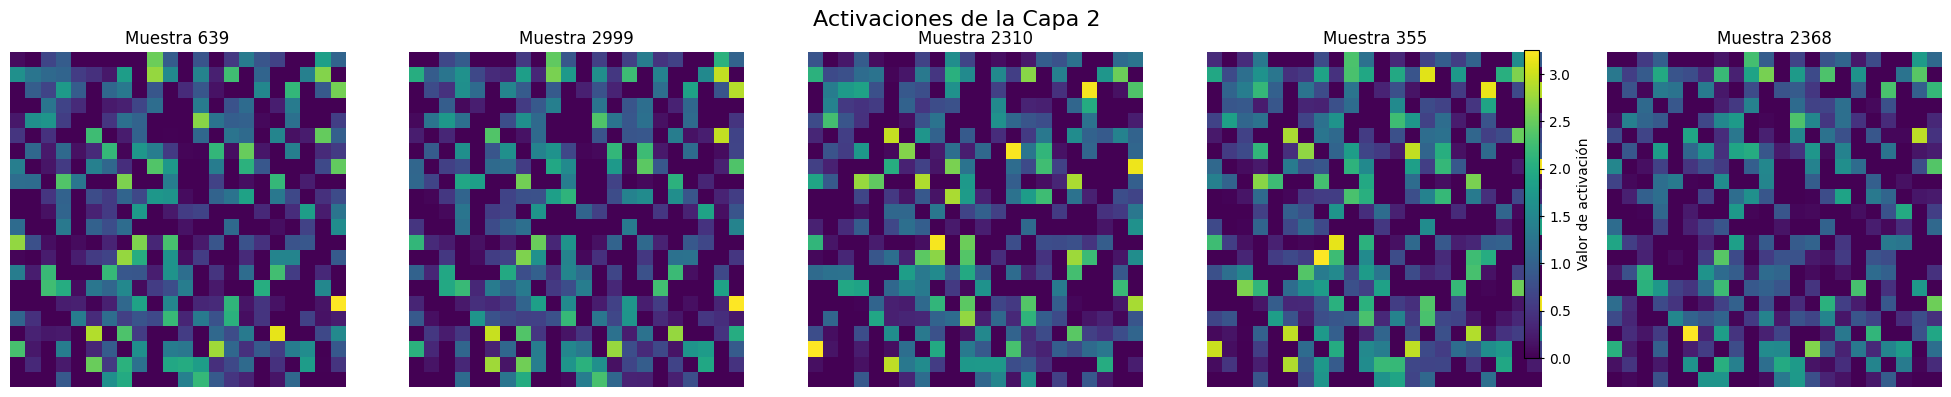

In [ ]:
def ver_capa(X_muestra, capa_num=1, muestras=3):
    
   
    if not isinstance(X_muestra, torch.Tensor):
        X_tensor = torch.from_numpy(X_muestra).float().cuda()
    else:
        X_tensor = X_muestra
        
    
    if muestras > X_tensor.shape[0]:
        muestras = X_tensor.shape[0]
    
    indices = random.sample(range(X_tensor.shape[0]), muestras)
    X_seleccionado = X_tensor[indices]
    
    with torch.no_grad():
    
        h1 = X_seleccionado.mm(w1) + b1
        h1_relu = h1.clamp(min=0)
        
        if capa_num == 1:
            activaciones = h1_relu
        else:
           
            h2 = h1_relu.mm(w2) + b2
            h2_relu = h2.clamp(min=0)
            
            if capa_num == 2:
                activaciones = h2_relu
            else:
               
                h3 = h2_relu.mm(w3) + b3
                h3_relu = h3.clamp(min=0)
                activaciones = h3_relu
    
    activaciones_np = activaciones.cpu().numpy()
    
    fig, axes = plt.subplots(1, muestras, figsize=(muestras*4, 4))
    
    if muestras == 1:
        axes = [axes]
    
    for i in range(muestras):
        n_neuronas = activaciones_np.shape[1]
        lado = int(np.sqrt(n_neuronas))
        
       
        datos_viz = activaciones_np[i][:lado*lado].reshape(lado, lado)
        
      
        im = axes[i].imshow(datos_viz, cmap='viridis')
        axes[i].set_title(f"Muestra {indices[i]}")
        axes[i].axis('off')
    
    
    plt.colorbar(im, ax=axes, label='Valor de activación')
    plt.suptitle(f"Activaciones de la Capa {capa_num}", fontsize=16)
    
   
    plt.tight_layout()
    plt.show()

ver_capa(X_test, capa_num=2, muestras=5)

# Error

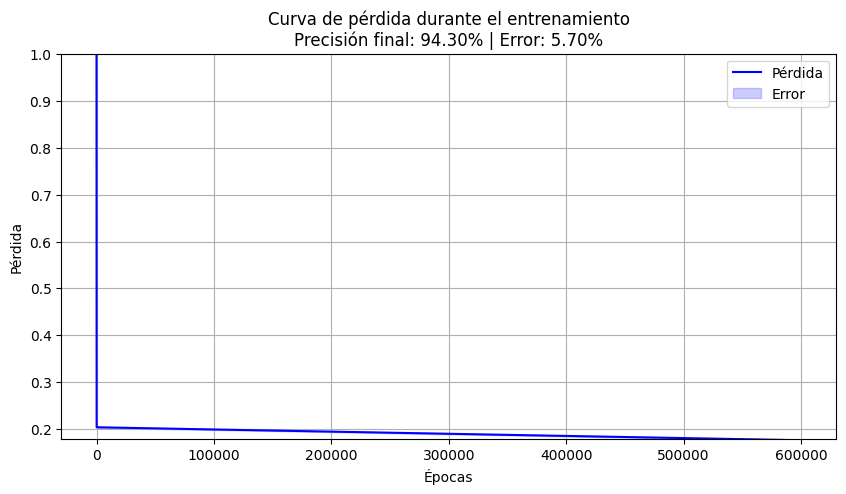

In [ ]:
def plot_loss_curve(loss_history, accuracy=94.30, log_each=10):

    epochs = np.arange(1, len(loss_history) + 1) * log_each
    
    loss_history = [1.0] + loss_history
    epochs = np.insert(epochs, 0, 0)
    
    error_std = np.std(loss_history) * 0.1 
    loss_history = np.array(loss_history)
    
    error_percentage = 100 - accuracy
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_history, label='Pérdida', color='b')
    plt.fill_between(epochs, loss_history - error_std, loss_history + error_std, color='b', alpha=0.2, label='Error')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title(f'Curva de pérdida durante el entrenamiento\nPrecisión final: {accuracy:.2f}% | Error: {error_percentage:.2f}%')
    plt.legend()
    plt.grid()
    plt.ylim(0.18, 1.0)
    plt.show()

plot_loss_curve(loss_history, accuracy=94.30, log_each=10)


In [ ]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())

y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy*100:.2f}%")


Precisión del modelo: 94.30%


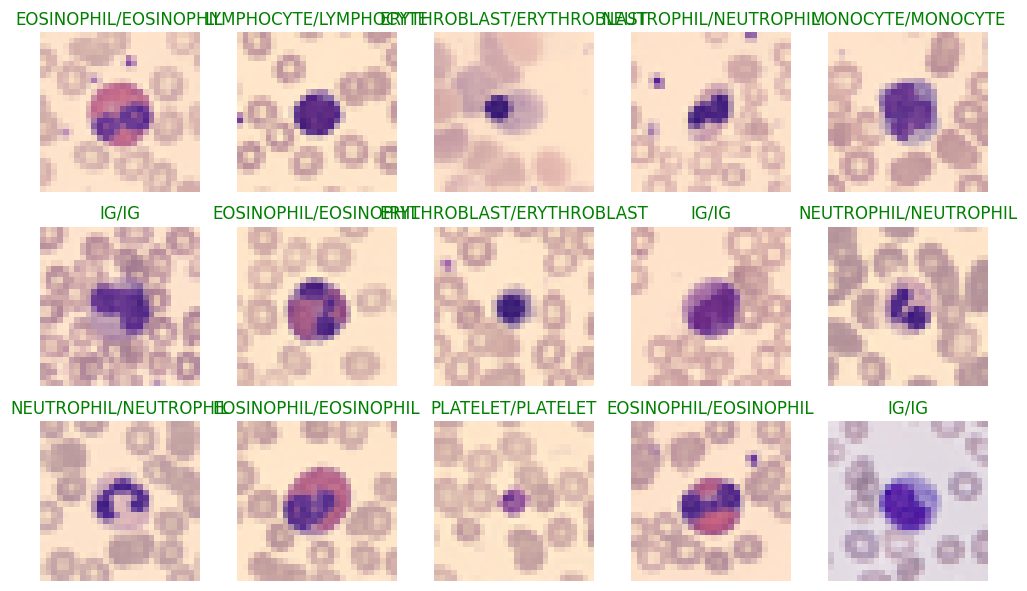

In [ ]:
class_names = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']

r, c = 3, 5
fig = plt.figure(figsize=(2 * c, 2 * r))

for i in range(r * c):
    plt.subplot(r, c, i + 1)
    
    ix = random.randint(0, len(X_test) - 1)
    img = X_test[ix]
    
    y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
    
    plt.imshow(img.reshape(28, 28, 3))
    plt.axis("off")
    
    true_class_name = class_names[y_test[ix]]
    predicted_class_name = class_names[y_pred]
    
    title_color = "green" if y_test[ix] == y_pred else "red"
    plt.title(f"{true_class_name}/{predicted_class_name}", color=title_color)

plt.tight_layout()
plt.show()